In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Removing repo
Cloning repo


In [0]:
# matplotlib setup
import matplotlib.pyplot as plt

%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
# logging setup
import logging

# make logger output only INFO from active_learning_ratio_estimation
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "active_learning_ratio_estimation" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [0]:
from active_learning_ratio_estimation.dataset import ParamGrid, ParamIterator, SinglyParameterizedRatioDataset

theta_bounds = (0, 1)
theta_0 = 0.05
num_grid =  101
n_samples_per_theta = int(1e3)
param_grid = ParamGrid(bounds=[theta_bounds], num=num_grid)  # all possible parameter points

theta_1_iterator = ParamGrid(bounds=[theta_bounds], num=3)  # initial parameter points in dataset

# test dataset
n_test_param = 10
test_iterator = ParamIterator([np.random.rand(1) for _ in range(n_test_param)])
test_dataset = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=triple_mixture,
    theta_0=theta_0,
    theta_1_iterator=test_iterator,
    n_samples_per_theta=n_samples_per_theta,
    include_log_probs=True
)

In [0]:
from active_learning_ratio_estimation.model import FlipoutClassifier, SinglyParameterizedRatioModel

estimator = FlipoutClassifier(
    n_hidden=(15, 15),
    epochs=5,
    patience=0,
    validation_split=0.1,
    verbose=0,
)
ratio_model = SinglyParameterizedRatioModel(estimator=estimator)

In [8]:
from active_learning_ratio_estimation.active_learning import ActiveLearner
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def fit_active_learner(acquisition_function, n_iter=15, verbose=False):
    if verbose:
        print(f'\n**** Fitting with {acquisition_function} ****\n'
              f'n_iter={n_iter}, num_grid={num_grid}, '
              f'n_test_param={n_test_param}, n_samples_per_theta={n_samples_per_theta}')

    gp_params = dict(
        kernel=RBF() + WhiteKernel(),
        n_restarts_optimizer=5,
        alpha=0,
    )
    active_learner = ActiveLearner(
        simulator_func=triple_mixture,
        theta_0=theta_0,
        theta_1_iterator=theta_1_iterator,
        n_samples_per_theta=n_samples_per_theta,
        ratio_model=ratio_model,
        total_param_grid=param_grid,
        test_dataset=None,
        acquisition_function=acquisition_function,
        ucb_kappa=0.0,
        validation_mode=False,
        gp_kwargs=gp_params
    )
    active_learner.fit(n_iter)
    return active_learner


active_learners = dict()
acquisition_functions = [
    'std_regressor',
    'random'
]

for acquisition_function in acquisition_functions:
    active_learners[acquisition_function] = fit_active_learner(acquisition_function, verbose=True)    

10:44 active_learning_rati INFO    Initialised ActiveLeaner; simulating initial dataset.



**** Fitting with std_regressor ****
n_iter=15, num_grid=101, n_test_param=10, n_samples_per_theta=1000


10:44 tensorflow           WARNING From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/layers/util.py:106: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
10:44 active_learning_rati INFO    Active learning iteration 1/15
10:44 active_learning_rati INFO    Choosing next theta to add to dataset.
10:44 active_learning_rati INFO    Calculating marginalised acquisition function
10:44 active_learning_rati INFO    Fitting, and predicting with, GaussianProcessRegressor.
10:44 active_learning_rati INFO    Recording acquisition history.
10:44 active_learning_rati INFO    Adding theta = [0.99] to labeled data. Building new dataset.
10:44 active_learning_rati INFO    Adding new dataset to existing dataset
10:44 active_learning_rati INFO    Fitting ratio model
10:44 active_learning_rati INFO    Finished fitting ratio model. Best ep


**** Fitting with random ****
n_iter=15, num_grid=101, n_test_param=10, n_samples_per_theta=1000


10:56 active_learning_rati INFO    Active learning iteration 1/15
10:56 active_learning_rati INFO    Choosing next theta to add to dataset.
10:56 active_learning_rati INFO    Adding theta = [0.97] to labeled data. Building new dataset.
10:56 active_learning_rati INFO    Adding new dataset to existing dataset
10:56 active_learning_rati INFO    Fitting ratio model
10:56 active_learning_rati INFO    Finished fitting ratio model. Best epoch information: loss=7.65E-01, accuracy=6.01E-01, val_loss=7.12E-01, val_accuracy=6.96E-01
10:56 active_learning_rati INFO    Active learning iteration 2/15
10:56 active_learning_rati INFO    Choosing next theta to add to dataset.
10:56 active_learning_rati INFO    Adding theta = [0.55] to labeled data. Building new dataset.
10:56 active_learning_rati INFO    Adding new dataset to existing dataset
10:56 active_learning_rati INFO    Fitting ratio model
10:56 active_learning_rati INFO    Finished fitting ratio model. Best epoch information: loss=7.31E-01, ac

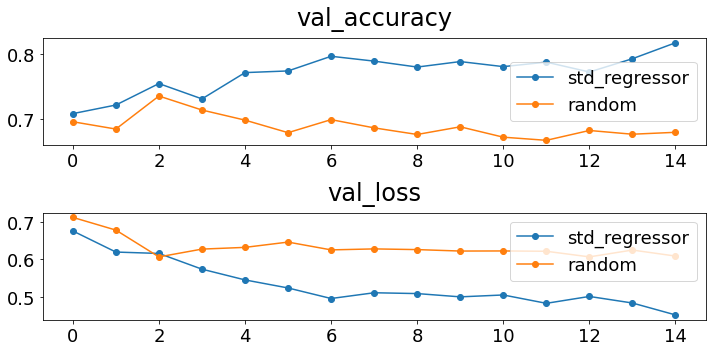

In [9]:
f, axarr = plt.subplots(2)
for acquisition_function, learner in active_learners.items():
    for i, quantity in enumerate(['val_accuracy', 'val_loss']):
        axarr[i].plot(learner.train_history[quantity].values, 'o-', label=acquisition_function)
        axarr[i].set_title(quantity)
        axarr[i].legend()

f.tight_layout()
f.show()

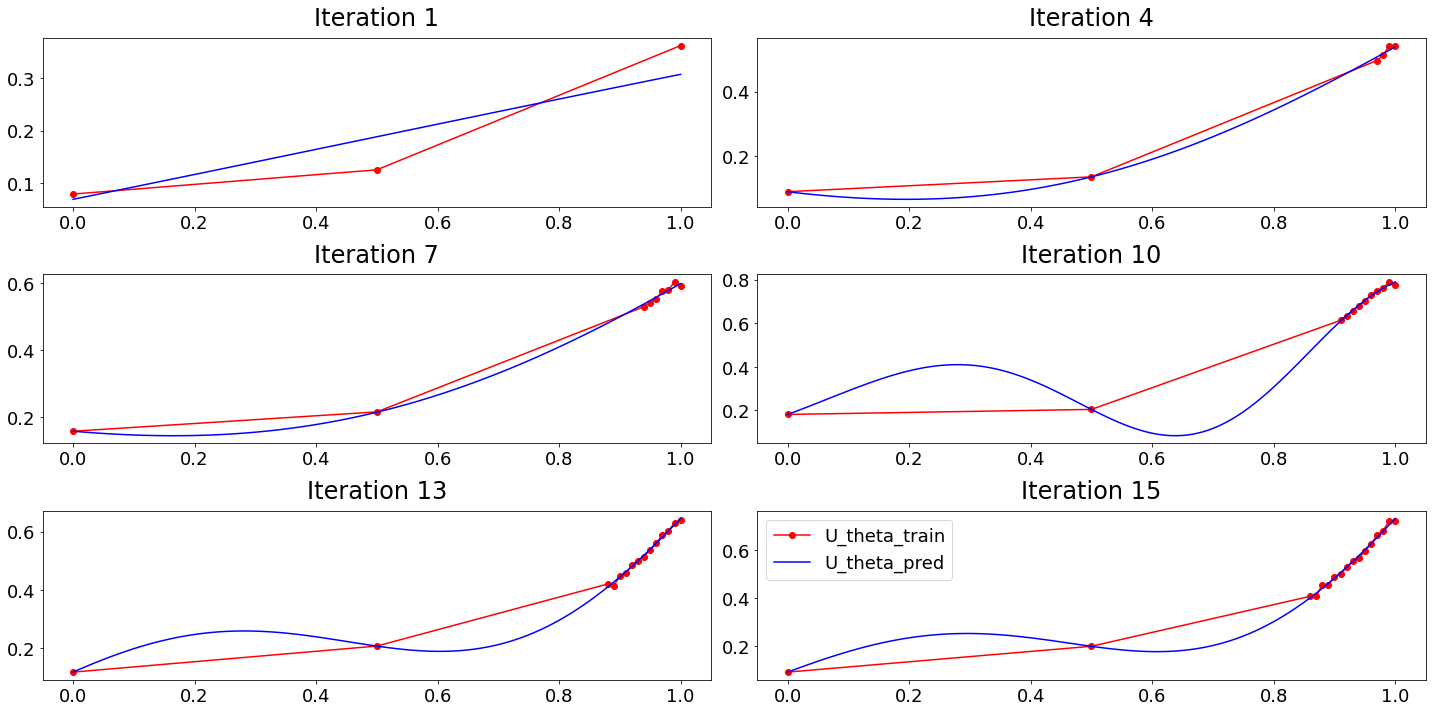

In [15]:
std = active_learners['std_regressor']
f, axarr = plt.subplots(3, 2, figsize=(20, 10))
ax_list = np.ravel(axarr).tolist()

for i, iteration in enumerate([0, 3, 6, 9, 12, 14]):
    ax = ax_list[i]
    std.plot_acquisition_history_item(iteration, ax=ax)
    ax.set_title(f'Iteration {iteration+1}')
    ax.legend().remove()
    ax.set_xlabel('')

ax.legend()
plt.tight_layout()